# Filtro de partículas - 2018


Todo seu trabalho deve ficar no arquivo `projeto_pf.py`, que deve ficar num repositório Git privado (que pode estar no Github ou no Gitlab). Você deve adicionar os professores  em seu repositório (fabiomiranda@insper.edu.br  e andrewtnk@insper.edu.br )

A idéia é que você trabalhe somente na `projeto_pf.py` e use este *notebook* somente para instruções e para testar o que fez. Quando seu projeto estiver pronto o arquivo GIF gerado vai mostrar as partículas convergindo para a posição do robô.

Cada partícula vai ser representada por um objeto da classe `Particle`, do arquivo `pf.py`, que contém os atributos `x`,`y`,`theta` e `W`.  O atributo `W` é a probabilidade. 

Este projeto é individual. Lembre-se dos [princípios de honestidade de código](https://docs.google.com/document/d/e/2PACX-1vTiAczPm5Vxi7TXphB135LFH-Munp9X8ISHkeujrTvJtOmQaCC1iAUkoPdHgvkWhIkLsE0e1-T3ZGJ3/pub).




# Atividades


1. Crie uma função que gera n partículas aleatórias distribuídas uniformemente dentro de uma área minx, miny, maxx, maxy, n_particulas (passados como parâmetros). Veja a funcao `create_particles` no módulo `pf` para se inspirar. Sua função deve se chamar `cria_particulas` e ficar no arquivo `projeto_pf.py`.  
Esta função deve devolver o número de partículas solicitado

2. Crie uma função que aplica o deslocamento pelo qual o robô padrão [delta, delta_theta] normal com um desvio padrão [std_deslocamento, std_theta] a todas as partículas.  Esta função deve se chamar `move_particulas` e está também no arquivo `projeto_pf.py`. As partículas têm uma função `move_relative` que facilita aplicar um deslocamento linear no sentido em que a partícula está orientada.

3. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles e de chama `inspercles.nb_lidar`.

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Dica: veja nos slides da aula a semelhança desta fórmula com a normal. Você pode usar `norm.pdf` para calcular.

Para cada raio real medido do robô $\hat{z_j}$ e leitura simulada da partícula $z_j$ calcule a probabilidade daquela leitura da partícula ter acontecido se o robô estivesse na posição em que a partícula está

Faça o traçado dos raios e o cálculo da probabilidade na função `leituras_laser_evidencias`, que também está no arquivo `projeto_pf`. Este traçado limita-se à função `nb_lidar`. Os *frontends* Jupyter e PyGame já fazem todo o desenho.

Note que o valor dos $P(H)$ calculados a cada iteração devem ir para o atributo `W` dos objetos da classe partículas. 

4 . Reamostre as partículas de forma proporcional à probabilidade na função `reamostrar`. Baseie-se no `notebook` chamado `como_sortear`, mas lembre-se de que você precisa incluir uma variação normal às partículas reproduzidas.  **Lembre-se também que depois de reamostrar as partículas precisam ter seu peso W tornado igual novamente**.

### Testando a versão PyGame

A versão `PyGame` usa as mesmas funções do `projeto_pf`, com a diferença que o filtro de partículas é executado passo a passo.

Para instalar PyGame

    conda install pygame
    
ou
    pip install pygame
    
Para executar, no Python 2 faça:

    python window.py
    
No Python 3 faça:

    pythonw window.py


Para funcionar bem com  versão PyGame, adote um desvio padrão do movimento das partículas bem pequeno, da ordem de 0.1 pixels. Quando o filtro de partículas é testado nesta modalidade o robô se move pouco de cada vez

### Atenção:

Instale o pacote attrs fazendo:

    conda install attrs



In [1]:
import projeto_pf # Seu trabalho fica em projeto_pf. Você não deveria precisar editar este notebook

import inspercles
import graphics_nb

import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline


if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    importlib.reload(projeto_pf) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(projeto_pf)



Using scikit-learn to compute nearest neighbors


## Diretório de trabalho

In [2]:
print(os.getcwd())



C:\Users\gabri\OneDrive\Documentos\Insper\3_semestre\RoboticaComputacional\Projeto2_robot18


Criação das partículas: chamamos a função `projeto_pf.cria_particulas()` para fazer a criação inicial. Estamos armazenando na própria `projeto_pf`. 

In [3]:
projeto_pf.particulas = projeto_pf.cria_particulas()
    

## Mapa com posição inicial

Você **não** precisa se preocupar com as funções de desenho. 

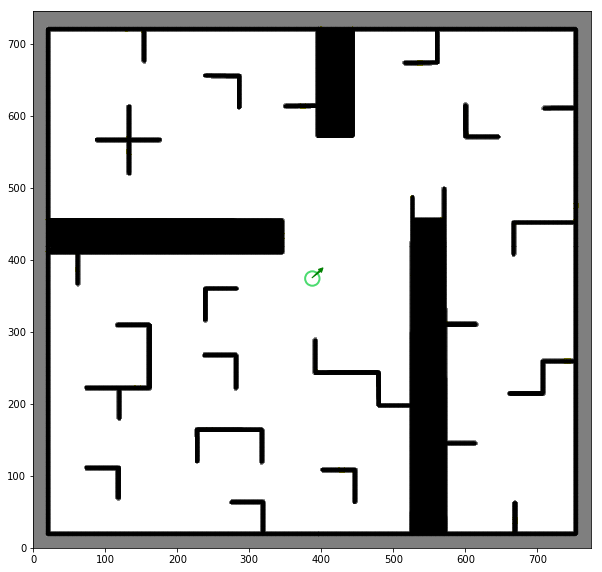

In [4]:
graphics_nb.draw_map(projeto_pf.robot)

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use `inspercles.nb_lidar` passando o objeto robô. 

Você vai precisar fazer isso dentro da função `leituras_laser_evidencias`(que está em `projeto_pf.py`). Haverá uma leitura simulada para o robô e uma simulada para cada partícula

In [5]:
r = projeto_pf.robot
leituras = inspercles.nb_lidar(r, projeto_pf.angles)


O *array* leituras é um dicionário em que as chaves são os ângulos do laser relativos ao robô e o valor é a distância em *cm* em que um obstáculo foi observado naquela direção

In [6]:
leituras

{0.0: 294.8635277547903,
 0.78539816339744828: 235.0,
 1.5707963267948966: 53.033008588991066,
 2.3561944901923448: 320.5,
 3.1415926535897931: 145.66399692442883,
 3.9269908169872414: 133.0,
 4.7123889803846897: 190.2117241391813,
 5.497787143782138: 134.5}

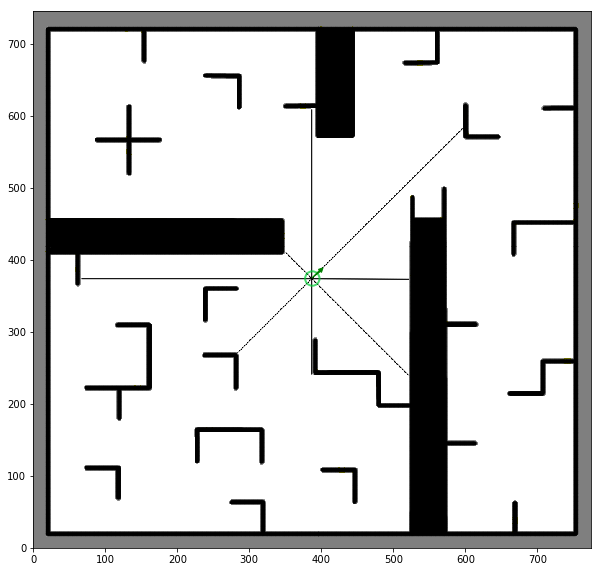

In [7]:

# Você não deve se preocupar com o código abaixo - é só para gerar uma imagem que será mostrada mais adiante
#leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
leituras, lidar_map_temp = inspercles.nb_simulate_lidar_desenha(projeto_pf.robot, projeto_pf.angles)

#plt.imshow(lidar_map_temp)
ax = inspercles.nb_draw_map(lidar_map_temp, robot=True, pose=projeto_pf.robot.pose())
#ax.imshow(inspercles.color_image, alpha=0.8)



## Loop principal dos movimentos do robô

Há uma lista de deslocamentos para o robô chamada `movimentos` no arquivo `projeto_pf`. Vamos usá-la para simular o movimento no filtro de partículas




Atenção: quando for gerar os arquivos png da entrega por favor apague todos os arquivos do tipo anim*png antes de gerar a versão final

In [8]:
# No Windows: 
!del anim*png

In [9]:
# No Linux ou Mac
#! rm anim*png

In [10]:
## Atenção: Você não deveria precisar mexer no código abaixo


plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio por causa da animação

frames = 1



for delta in projeto_pf.movimentos:
    
    projeto_pf.robot.move_relative(delta)

    projeto_pf.move_particulas(projeto_pf.particulas, delta)
        
    # Simula a leitura do lidar para o robô - versão desenho
    #leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
    leituras, lidar_saida = inspercles.nb_simulate_lidar_desenha(projeto_pf.robot, projeto_pf.angles)
    
    # Simula a leitura - versao codigo
    
    
    # Simula o lidar para as particulas
    # ATENÇÃO: o "for" abaixo faz parte do que deve estar dentro do seu 
    # leituras_laser_evidencias (parte da resolucao do item 3)
    #for p in projeto_pf.particulas:
    #    leituras = inspercles.nb_lidar(p, projeto_pf.angles)
        
    # Atualiza probabilidade e posicoes
    projeto_pf.leituras_laser_evidencias(projeto_pf.robot, projeto_pf.particulas)
    
    # Reamostra as particulas
    projeto_pf.particulas = projeto_pf.reamostrar(projeto_pf.particulas)
    
    # Desenha as particulas
    ax = inspercles.nb_draw_map(lidar_saida, pose=projeto_pf.robot.pose(), robot=True, particles=projeto_pf.particulas)
    #ax = inspercles.nb_draw_map(lidar_saida, particles=projeto_pf.particulas)
    # Desenha o mapa do lidar como fundo
    ax.imshow(lidar_saida, alpha=1.0)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')



plt.ion()



[0.0005290527472444032, 2.2137024029184226e-07, 0.0021027037584804525, 0.0005180818891542715, 0.0, 0.0018729406896949294, 0.0014016670407718734, 0.0006830185270669794, 2.692150232603488e-05, 0.00101584637308775, 2.452090788166812e-63, 0.0015695422808406979, 0.001443294240778522, 0.005817996025744491, 0.002503239668818722, 1.384951523128961e-15, 0.0019173048492374424, 5.856790946940976e-09, 0.0018804295571444212, 3.147746749543466e-39, 0.0006190804439481082, 0.0024228171196495995, 0.0, 3.290907066867831e-287, 0.0007454421879008707, 1.1425807019206624e-06, 8.859262248599994e-06, 0.0017108493552587035, 1.8144415484217958e-05, 0.0018281330465478032, 0.0020910708246305904, 1.215964747347556e-07, 5.868293401482532e-05, 0.0008388613849376425, 0.0006141714031094763, 4.189554093485865e-05, 1.3365371818932108e-78, 0.0007726359707686406, 1.6792846622032467e-05, 0.0004531539515033771, 0.00025244213266253896, 0.002235509327779291, 0.00010266497170784047, 4.338684548181075e-06, 0.0022771184844343003

[0.0001391204562410194, 4.702601883505139e-05, 2.7794103332430015e-14, 0.0022588346272092927, 0.002415089561898025, 1.2453068067053306e-08, 0.001849285520980293, 5.433403819254874e-06, 3.0602369522512513e-32, 0.0005760734278695339, 6.413259651369111e-09, 0.0014954616856592243, 7.211707872531126e-09, 0.0022595288714391424, 2.871734660551115e-27, 0.0015719464780198883, 4.836723250454073e-05, 0.0017621174892950707, 0.00399764991194951, 5.203313863715308e-21, 9.527870838781692e-05, 6.663183179875561e-11, 0.0021855306090803584, 0.0021010420891435988, 2.3961089803559828e-35, 0.002663037733688622, 0.0006595774751107735, 0.0009048447319997031, 8.538669167451972e-09, 0.0005988825729877225, 3.0622213731897665e-13, 6.949698219962045e-05, 1.2711653864516391e-17, 0.0017168772064869325, 0.0018675554243101165, 0.0032063253034629825, 0.0022558246283374142, 2.6444866902589908e-08, 4.9222518741122074e-08, 6.361478579783581e-05, 0.001809281723960136, 0.0018311157051682735, 0.0018733804415577678, 4.417514

[0.0015026932784618413, 8.186098425031337e-08, 0.0009536360117916439, 0.0, 0.00015357760385016045, 0.001048425755364956, 5.9173997896082804e-49, 0.00013015707619435892, 0.0017132119506277279, 0.0023331290852779134, 0.0013729394660052549, 4.187756132032434e-06, 0.0009735524351183433, 0.0025056615883415688, 0.0018402906474453782, 2.568482738764845e-13, 0.0007031402831241868, 0.002567076302531173, 0.0004177738746870517, 8.41818216121803e-10, 2.1657793132725057e-19, 0.0013543672086364896, 0.0006537042710592938, 0.0014673812807733813, 0.0010378187728571275, 7.737235750675229e-10, 7.535805759641392e-05, 1.2892677848463321e-06, 1.6646102122427671e-37, 0.0008894169686182995, 9.792090726195675e-05, 0.0026523223123681907, 0.001859252067235844, 4.2042924773283746e-26, 0.0007771010769771272, 0.0013860664332019578, 1.3231949518239086e-51, 7.689120523795416e-08, 0.0005448774663382543, 0.0, 7.445439862041181e-05, 0.0, 0.0014776263598876222, 0.0014303897225582147, 0.002828066354732995, 0.0006618973602

[7.008541276976453e-05, 0.0012431983203781125, 0.0018636296007057507, 1.2297196908732424e-07, 0.0012565621869801852, 1.0051695156426107e-08, 6.025821367317029e-06, 2.0414699536847273e-05, 0.0008815125116440292, 1.4873154943457519e-05, 0.0026006605221672095, 6.489734141312318e-07, 0.002288210885379236, 9.60353778546756e-10, 0.0008510297961917374, 0.004456199017497352, 0.003647744822240543, 0.00015586040745361237, 0.00017714701359556085, 0.00013375247891274448, 0.001507011119086451, 2.5251081176058182e-08, 0.0011933337185428636, 0.0003856996376321703, 7.534746034995555e-05, 0.0017368700907486726, 0.0013983125133164446, 0.0004582909555754774, 0.0009462806492023784, 1.2145898625112497e-06, 0.0013054000219099825, 0.0018266732917197241, 0.0025152113254840853, 6.081454326876577e-07, 0.002491394473086774, 0.001433808777413339, 0.0010963114430576064, 3.905100566217814e-07, 0.000502548443879862, 0.0020904420660418097, 0.0034517540762479507, 0.001382906907459, 1.5440285453108205e-06, 0.0001780998

[0.0014471687487891433, 0.0019206190271504006, 0.0, 0.0021500225601237565, 0.001718739756489255, 0.00010863729403333145, 0.0015052133383730328, 0.00048770860283682365, 0.0032448942837997336, 1.0760847294745813e-10, 0.0018524336291568708, 0.0021963955771422197, 0.0012962206870322456, 5.50318188884217e-05, 0.0013097214447612162, 0.0005939411238381015, 0.0011638864393842343, 4.274129719476e-311, 0.000937364200422521, 0.0, 0.001901715318900196, 0.00244563211403956, 0.0013876119827372598, 1.9437851961397414e-06, 0.00047872149435331483, 0.00016212022674578756, 0.0016984771883232158, 0.0012787805329769772, 0.0002046406400787822, 0.0008624944033885922, 0.0017857256269614835, 0.00278968868586552, 0.00046263145753397877, 0.001291228184988877, 2.269488164953226e-14, 6.346783868144581e-06, 0.0004974853272005934, 0.0010688803397005753, 0.00130694667557508, 0.0014357987232910428, 0.0014346319804570912, 0.0010796894464059016, 0.0012570473062946317, 0.003263031560982188, 0.0004797997419861137, 0.00308

[4.0774272707484497e-05, 1.3308977941594396e-06, 0.000156689140799081, 0.0012661209662877878, 0.0, 1.8145903969873464e-22, 0.0014059004290930606, 0.0013157589168441366, 0.00046504879179856353, 0.0029912141859028125, 0.002195815232084798, 0.0016700565728434875, 0.00025183804871157644, 3.517774843759564e-05, 0.000175381667531375, 0.0015198111502026674, 0.005064302664994725, 0.0012030299825878865, 0.0006990292913944706, 3.723457886092895e-05, 4.676033438459377e-15, 0.0008555758336361802, 0.0002546359941495092, 0.0006152617865859529, 0.0026428608697100404, 3.641263624982316e-11, 8.837256648709285e-15, 5.1802896585576125e-11, 0.0005293110262262344, 0.001219535523326044, 0.0012745774562400785, 0.00020039259905466997, 0.0014117203974757682, 0.0006163681648891125, 0.001068048713109965, 1.6139465916314061e-07, 0.001317172201557034, 1.1865317896635426e-08, 2.035660387912586e-05, 0.00010941971557542392, 0.00345461336191971, 0.00038901503480333425, 0.0002777191999757919, 0.004103822546871058, 9.20

[0.000788711727632721, 9.003203130653841e-05, 0.0008113189459660867, 8.612943522705358e-06, 0.0, 0.0001356175044372888, 0.0013447822026662884, 0.0022323981827448713, 0.0015944283314466821, 0.0014603059269137156, 0.0018194428984086022, 6.632617332434982e-11, 6.421597548656018e-99, 4.491003036565789e-06, 0.001921565598475182, 3.962834072973956e-07, 2.8415783456052347e-07, 0.0025158057941649927, 0.003739309613052169, 0.0002579443101776438, 0.0023384139923164917, 0.0015038204786604699, 1.7490994505084425e-176, 0.0017086782837862516, 0.0014261015526148846, 0.0013348023392539545, 0.0014519774549154726, 0.0035103273273267665, 0.003976214136619145, 0.002582698832375978, 0.0013069986208439222, 0.002864796566139131, 0.0016304880251315746, 0.0024964955068657035, 0.0022677575117755738, 0.0013892094158667137, 0.002513971837405171, 0.0003210286378643978, 0.0009481024846575283, 0.0014399657939496904, 6.593548898368065e-08, 0.0012713419893887626, 0.0015677560362124482, 0.0003864553789712169, 0.0, 0.00

[0.0009288630573257632, 6.851203769992991e-48, 0.0001208515864849859, 0.0014429062189904576, 0.0003585174085652733, 0.0013692750665609157, 6.583900408598967e-18, 0.0004347566619826877, 0.0013889443177020782, 0.0008341708646090791, 2.6849424370607257e-13, 0.0028908483177711593, 0.001113294262395912, 0.0005481872513851574, 0.0015613124908662776, 6.321905204608337e-10, 0.0010264842292339509, 1.2393635593000758e-06, 0.0016129172499344223, 0.0013532623994850113, 0.00019605210999706923, 1.8239988410665278e-05, 0.000724577780118737, 0.0024473744680207662, 6.199557247163146e-147, 0.0020367697142996744, 9.447148352925326e-07, 0.00012506183627193553, 0.0059068443429515, 1.0916052414996507e-06, 0.00023763279954066132, 1.3975395123933309e-11, 3.0538327265558387e-09, 0.0010854142734315225, 0.0014858161677994705, 0.001500054412891182, 1.0857630388150972e-05, 0.003134255261438776, 0.0028696993112747983, 6.8270084185835e-05, 0.0028248985506674437, 2.3271334658348478e-08, 0.00022334820850022905, 0.0014

[0.0007332040519071185, 0.0003095769386524525, 0.001560319842145945, 0.001482079057050855, 0.0003270762960550428, 0.001582796227703107, 0.001503027026608035, 0.00023331566125212386, 0.0023787169927287645, 0.0027296740817736426, 0.0011459468823799741, 0.001890454603856679, 0.0009017069904345344, 5.436949014681804e-10, 0.0011144367258892098, 0.00047154222020605633, 0.0019662775792983482, 0.0009334609985189126, 3.189507879074031e-05, 0.0019760310285948345, 0.0005584293965487574, 0.0010999038856948033, 0.0006405271207142259, 0.0032268683875217104, 0.0013853293394472978, 0.0020989438171552634, 2.2990821164326252e-07, 0.00020617110705872148, 0.0006999380146806152, 0.0011323214151846002, 1.1519862798686833e-07, 0.000532288976089053, 0.002837526590262097, 1.4036985259380948e-10, 4.741462750385048e-05, 0.0012951681700191853, 0.002451967912160993, 0.002670083539778427, 0.0005670261536909977, 0.0024246945149093, 0.0004589105004779191, 0.0011391469927586886, 0.0025177555723209432, 0.00240669526825

[0.0020383194537110616, 0.0011425013409743954, 0.0017309457874531856, 0.0018305810559612916, 1.9329442715301926e-05, 0.0010380092744202668, 0.0005046608148955563, 0.0028080343763154853, 0.00020477372632228172, 4.347417751071982e-06, 6.997533714842051e-07, 0.0010606154186820337, 0.0024573701280917693, 0.0002545573133906392, 7.517025187113699e-06, 0.001099623150507932, 0.0010268672412843413, 0.0012415076309694358, 0.0006883997310504609, 0.0009453596277671773, 2.5473216366898896e-06, 0.0013403395156957978, 0.0013395415091465783, 0.0010843644468375212, 0.0013438354150041635, 0.0012759365237405484, 0.0018385199529265862, 0.0003006675170864798, 0.0011464802632087051, 0.0003028358185522569, 0.0009403895106182703, 0.0021633278608924294, 3.889773685817178e-05, 0.0011507203695991532, 0.0013431802100741773, 0.0009708695127983993, 0.0011477691782846788, 0.00048468103010549816, 0.0012194078951564505, 0.000968878973755439, 2.832781719121307e-09, 0.0014941908018369168, 0.0003328883648997322, 0.000708

[0.0008369111485299004, 6.282160872263473e-19, 0.0009820547612470554, 0.0005629430310503837, 0.0010610521536933894, 0.0006703644737154532, 0.00301599503427738, 1.98070206403e-313, 8.195996495460261e-07, 0.00046597720943236036, 6.722116994370726e-05, 0.0008797437506304763, 0.0013809169776907754, 3.5595951543782444e-06, 0.0009805300881534705, 1.442114070076978e-06, 0.0005295115478911526, 0.00079201367724889, 0.0002776899708538799, 0.00024171150679240362, 0.0029596893132095544, 0.0009660714397361353, 3.032408907338329e-06, 0.0013784119225573816, 0.0010621699139127746, 0.0015823951154491874, 0.0008327290354932139, 0.0007571452825332976, 0.00024349836845408856, 1.8385628519490926e-44, 0.0010265637366490893, 0.0018156335801907037, 0.0011555589411301889, 0.002906132124585033, 0.0010719806612204082, 0.0008372437840864272, 0.0024856721742313698, 0.00019513467022266805, 0.0005258918994288008, 0.0008435256781395703, 0.0012636768763025783, 0.000646650653363873, 0.0009615954810354039, 1.71270209019

[0.0005054286773110827, 4.3019691237719175e-24, 0.0003263263165587912, 0.0009145582117544563, 0.0004477268783488534, 0.0006212026593880757, 0.00019825520202819747, 0.00023564542240389833, 0.0010798638498857966, 0.0009278243733224607, 0.0010273491598976846, 2.7266195831291707e-06, 0.0012135908596010794, 0.000733851910399483, 0.0005370580688777998, 0.000742087846154809, 0.0008701315593416801, 0.0006620484407863608, 0.0005066260063742946, 0.0009047228033868651, 0.00021054309155570694, 0.0004912127872549869, 0.0008748615185892255, 0.0029328285746364497, 1.5327732566286174e-22, 0.0009840828525864132, 0.0002816585144702957, 0.0023673712000207396, 0.0016883791162383786, 0.0009345707062191855, 0.0016223379660252934, 0.0007302288460959167, 0.0019511019002097822, 0.0019475096384691181, 0.0009851101852283567, 0.0009274962502557627, 0.001059270462856264, 2.951196096696739e-20, 0.0005371224941766675, 0.0005649009133633195, 0.0025809904384614404, 0.0019612716931314, 1.5239387892771436e-07, 0.0019050

[0.00238309884705116, 0.000553827635674795, 0.000880829644548268, 0.0002947931438402476, 6.212326039460078e-05, 1.1043320122512429e-10, 0.000938018060225548, 0.0013929874577218847, 0.0013813860005224127, 0.0007580404547057562, 0.001799232014978887, 0.0013977344494540724, 0.001625291454994709, 0.0016930358254227083, 0.0016541848536253268, 1.3368814011135691e-05, 0.00286351705668404, 0.001873219095051909, 0.0015358097170030567, 0.0017687369843499292, 4.2132326537018374e-06, 0.0009666682947921259, 0.0015803022357520978, 0.001386969355839137, 0.0009199047919896431, 0.0006196163913349589, 2.3588142507153534e-05, 0.0010141639242838881, 0.0009558765513341662, 0.0039856543340972385, 0.0018598536260085014, 2.632271233853203e-05, 0.0031114903107844426, 2.67270839896055e-14, 0.0023660144476995064, 0.0009119490805984889, 0.0006720095497777523, 4.4561762650209045e-15, 0.0006576454100423808, 0.0011906930465957822, 0.000625923328566166, 1.5186086103661416e-08, 0.0011536970224588674, 0.001849864265438

[0.0017990446186369226, 0.0009402489201138127, 0.0005960138806045218, 0.0017905670961712646, 0.0016994579031688454, 0.00015341015256437548, 0.0015104445863946133, 0.0014567383922149842, 0.00012039431882999314, 0.00039885521755403586, 0.001571735057765933, 0.0026257493534209797, 0.0014943471897393152, 0.00035110974383834915, 0.001160836156221264, 0.0021226180065183464, 0.00038301732970757546, 0.0029961106760458024, 0.001261871408259406, 1.3775831371403733e-06, 9.862544894953621e-05, 0.0003340962294648884, 0.0006752599815389831, 0.0009219098415551193, 0.0008079050421338104, 0.000875067371169835, 0.0007701534473575887, 0.0010716810109388682, 0.0020789167738669806, 1.9708224545673055e-17, 0.00031934928534107414, 0.0008901992391027735, 5.2102003357094e-08, 0.0009104977528739626, 0.0008550630729795921, 0.0007682937001797489, 0.0005409831534132439, 0.0010059599155167122, 0.0009533652016020145, 0.001310014723546464, 0.0012561398858334735, 0.002895678329340377, 2.6814047236643438e-06, 0.0012499

[0.000982978138728518, 0.0008952842525380971, 0.0013554716337792927, 0.00195949755427999, 0.0004952436295688939, 0.0005006199472471516, 0.0013759695724109662, 0.0016710135268347625, 0.0018089810617603062, 0.0017401098842856526, 9.086017338566957e-14, 0.001835424132639326, 1.2058915317585244e-05, 0.00046406092793190907, 2.272734224230521e-18, 0.0015419495087692797, 0.0018358423997986608, 0.0006068831360427289, 0.0019486220606608805, 0.0011959275794441303, 0.002033868474466761, 0.0010784442223361241, 0.002228487778681581, 4.683639369970057e-05, 0.001646804469520192, 1.875666830794033e-05, 0.0015227893307788308, 0.0004341262890331263, 0.0001562071938105829, 0.0009720736561331343, 0.002021253450490464, 0.0008361445107009371, 0.0013081918043550663, 0.00038009831243872663, 0.0011029905980889136, 3.1680085690947e-11, 8.87066470604386e-06, 0.001653157526679169, 0.0014194914477980406, 0.0010073285589766413, 0.0008397267679597312, 0.0004985534185455473, 0.00012331464336240514, 0.0008036743154606

[0.0012722800655709792, 0.00027685798072000123, 0.0011657858443345967, 0.0017519120536220545, 0.00127956113502787, 0.00025876857535210026, 0.0009110245333797414, 0.0007029612857989751, 0.00014805217480332549, 0.0005627973704173802, 1.141823334648675e-46, 0.0011650768332358698, 0.0008750260535177071, 0.0012912758364052991, 0.0007092710124120317, 0.00039165697973529234, 0.0014269224944252847, 0.0003238712514301956, 1.5059055233812625e-05, 0.0021212306250906403, 0.0008538725681949753, 0.0013635072460055555, 0.0014106720886349576, 0.0009559615024475952, 0.0003474135853927294, 0.0003049537081943556, 0.00022582812380374695, 0.0014814867205452996, 0.0005993774946164193, 0.0012076809209725016, 1.369655867830909e-10, 0.002362163705023918, 6.005769719847244e-07, 0.000842538895239574, 0.0008041445282931969, 0.0009339523091976511, 6.274224092646345e-07, 2.5386186026289767e-06, 0.0011726557744212594, 0.0012407798193457388, 0.0010705273047820023, 0.002477536528800295, 0.0011277089636165963, 0.001563

[8.06847883489987e-05, 0.0010550420993309653, 0.0009142442024992523, 0.00113893608873531, 0.0006617270958126447, 0.004098891145313966, 0.0016573974306337853, 0.0014183198414343427, 0.0004699496734738262, 0.0010851005727129605, 0.003143621307482952, 0.0021082441494376628, 0.0014504874570516293, 0.0001737991300405736, 0.001742770273337278, 0.0018075061116081578, 0.0007155434107256563, 0.00011930343590221575, 0.0006764712273689206, 0.0008679179139863873, 0.002443896810728293, 0.0024263561729664287, 0.00024086625962767066, 0.0007579902426484591, 3.4675425026442934e-11, 0.0012786071699374295, 0.0019390510161369947, 0.0007584568077255471, 0.0018322100430268572, 0.0018125061748560153, 0.0006884058720284904, 1.8759209904765363e-13, 0.001925561617537882, 0.0012240468062647506, 0.0006622039584178762, 0.0017556990786396073, 0.0009242986456620794, 0.0012539188696750875, 7.122161460272615e-05, 0.0002115236630078489, 0.0014706632347253866, 2.729559755048415e-05, 0.0007785265611658149, 0.000319729485

[3.3778435855182695e-06, 0.0026215429485506162, 9.009401018336787e-05, 0.0014400293671668106, 0.0005806304998733417, 5.242313966284289e-26, 6.637586857780731e-05, 5.445663389524648e-05, 2.2407704651828733e-05, 0.0012312054693485422, 0.001882702425727292, 0.0010721398803835306, 0.0016655093682257202, 0.0008324406224568945, 0.0011237807189771107, 0.00017021423983199229, 0.0005855173017468751, 0.0012473840418633305, 0.0003787800329019063, 0.0003144741108592041, 0.0005463188454887068, 0.0014688494379709507, 0.0010023078366370765, 0.0010165479213608201, 3.149085360208102e-05, 6.899273987117303e-05, 0.00047516339284320227, 0.0001062521346893345, 0.00014724505066531402, 0.00014441583050454838, 0.0015058110623123126, 5.312137116538233e-06, 0.0007372321624264204, 0.0007751488933390504, 0.0010856759749190016, 0.00016175776385185493, 1.0665318403695566e-06, 0.0014576623507168412, 0.000634510024259129, 0.003253204284137796, 0.0010235223440005574, 0.0009529716894950761, 0.001265989704893822, 2.5556

[0.00014119464593148834, 0.001821183100256265, 0.00027240745407732095, 0.001954079874234503, 0.0010854732613892405, 0.0006898122779176305, 0.0015384693630939071, 0.002375404302945991, 0.0005094417963792968, 0.0017560674588282905, 0.00033542605981445097, 0.0004979041465945945, 0.0012289287122576092, 0.0009966027731339914, 0.000650657041562796, 0.002321630864372027, 0.0012661334527318945, 1.945317441186473e-21, 2.2266826095051765e-06, 0.0010890468890898555, 0.0004809063626464508, 0.0009900059160569742, 0.0028634988286197274, 0.0006348289612640928, 0.00014039528232794935, 0.0006654334741391165, 6.096717304357522e-05, 0.0007399314565204398, 0.0017826178839304564, 8.32413831531705e-07, 0.0026709342881426627, 0.0012610665803372164, 7.395880555139617e-06, 0.001024171634182008, 0.0012539115343486304, 0.000840843454359971, 0.0019007249612500547, 0.0019723310170696065, 0.0021154234647111484, 0.001388905336187395, 0.000762317085591119, 0.003109187824056033, 0.001485786980517277, 0.003181310782109

[4.967626390278222e-05, 1.1500348094601076e-73, 0.00015060464369437014, 0.00015278038432219008, 0.0007937898360973821, 5.0480131685843224e-05, 7.500376790976712e-05, 5.184709969164068e-05, 3.96590402112569e-22, 0.0016098955607456785, 8.007818941330298e-05, 0.0006835609912422014, 0.00012926469045462438, 0.00014950703322701454, 0.00015663755814038943, 0.00018654845152121273, 0.0001977111240996359, 0.00011102971412088181, 0.002915834822205361, 0.002254984640106113, 0.0008711159190717056, 0.0009144241037800007, 0.001998468780522253, 0.0016567605472956035, 0.0005751304155123284, 0.00013572091689489875, 0.0007659391140646205, 0.004246532260717051, 0.0008711884193808591, 1.8692437651270235e-07, 0.0023444816928797022, 0.0005041308984322185, 0.0025256348283220773, 0.0009269952768709795, 0.0008129143009000303, 0.0008027028274053815, 0.00028493726569881546, 1.0708544880596652e-52, 0.00010432487416225751, 2.877405671740043e-05, 0.000701430437122112, 0.0004990759499572256, 0.004411310765817261, 8.4

[0.0009477447570067774, 0.0016833785741184747, 1.298475540090862e-06, 0.001564963346386555, 0.003001158479449242, 0.0002554643333500195, 0.0014356653235928138, 0.0016714250720038428, 0.0008485237952037229, 0.0022849306312838404, 0.002654779623415965, 0.000241547055837648, 0.0013216513352133717, 0.0009454718981798898, 4.495026632133513e-08, 0.0010018950844474228, 0.0014302596214788826, 0.0017368739234689626, 0.0015392156149947908, 0.0012084463596647873, 0.00028850054943307577, 1.5124156661169832e-05, 0.0017334101421242708, 0.0012462396046300725, 0.0021791832195334274, 0.0004412950298682094, 0.0010861937642966542, 0.00013122054917177919, 3.318033738078535e-07, 0.0008906159303265055, 0.0014605643412353485, 0.001428739253534488, 0.0014843283611799597, 0.000486243916811494, 0.0002389301162691007, 0.00019155659438157578, 0.0015550180387137102, 0.0017241621966393361, 0.000997289967153907, 7.67634610437652e-05, 0.0007751021111723064, 0.0022166213221792136, 0.002484068839764334, 0.0030662475188

[0.00248696182190161, 0.0008042374295608692, 0.0003097129724718542, 0.002794580404858861, 0.0014703986976048096, 0.00013457299858069937, 0.0019323135575435829, 0.0016154385625975114, 0.0012994117414560874, 0.0014192606746167202, 0.00011315453379750463, 0.0008946149798284826, 0.00014037272562610344, 4.3050366590640625e-05, 0.001438587619603276, 0.00017543682901612363, 0.0005769334565437454, 6.608715002186909e-05, 0.0008297313625292419, 0.001115177058837863, 1.7495052217851904e-12, 0.003786975311097799, 0.0009946621892135848, 0.0006449513740879985, 0.0007769059285296462, 0.0003444627864803506, 4.524981724904764e-05, 0.00010348503680328529, 9.937152955457273e-05, 0.0009537893167687088, 5.862635170977926e-15, 0.000541539615747449, 0.0028614015472842496, 0.00011980046947156197, 0.0026514246115443363, 0.0038139372707079993, 0.0026517250679639033, 0.002132522378254784, 0.0011355524754108044, 0.000915916640417975, 0.0008193196795466556, 0.0007660093774004548, 0.00143880866360667, 0.00155886322

[0.0006396588121184962, 0.0017647541813219667, 0.0036553934011827253, 0.004379134608465518, 0.001142585743458105, 0.0003181375831463791, 0.00182904316634514, 0.00024242310873365166, 3.142753112403445e-06, 0.002753389171941411, 0.0014579737684877838, 1.348212433856226e-06, 0.0029558332333680906, 0.0016298429585276954, 0.0017525866239416971, 0.0006658805095789704, 0.0017427032053472652, 6.685618589519943e-05, 0.001217875684096626, 7.140508025622214e-44, 7.752995751768311e-43, 0.0029010023411116595, 4.468781017145781e-05, 1.7651760364938793e-23, 0.0011523533870206257, 1.3238772590410191e-15, 0.0033026263340696343, 0.0015615644588157663, 0.0020447092073180378, 1.3838722385379057e-48, 0.0008756914704284669, 0.0021517308187320354, 0.0009123282860245211, 0.003348395214206007, 0.0016717564456451947, 0.001034509786008287, 0.001637337909070656, 0.0013406596566351314, 0.0015779528884521253, 0.0013029201545760464, 0.003391491257899495, 0.0007224240628949975, 0.002068686492980466, 0.001147397208507

[0.0009011022496176924, 0.0006038290939038594, 0.0002025430618792231, 0.001422787078981759, 0.0024513332288758328, 0.0016041155572819855, 3.216334385179061e-33, 0.0010012441979524484, 0.00010748398295980626, 9.628241394367094e-19, 0.0003866778742612196, 0.0016777541163858144, 0.0017311650065608755, 0.0011379479559749358, 0.0020857734800022285, 1.0801343962463853e-15, 0.001123843141266683, 0.00023928695781956304, 0.001676059941400396, 0.0009430227326798187, 0.002251951833887251, 0.0009420664272378209, 1.0630630746735557e-91, 0.0014761059106470904, 0.002795221505453385, 0.0004792659612707274, 0.0009744004665416302, 1.2632701043685789e-12, 0.00038650972912268535, 1.1228958707932914e-27, 0.001808448689911567, 0.002321031535392265, 0.0009799443246809373, 0.002685640161419576, 0.0017879292430713963, 0.00047136877567797395, 7.063335572014656e-12, 0.0022552169196694977, 0.0022506715708852814, 0.002401177424617452, 0.0001660986756124918, 0.0009796847223819242, 0.0008540207994618723, 0.002802019

[0.0021421340333970156, 0.0010632061136157096, 0.0009167030812137063, 0.0008453829762573874, 0.00014910399992978983, 9.642966972564097e-28, 0.0011264788402231213, 0.0021914361227678134, 0.00027242540803977896, 0.0005972350415655511, 0.001821356537359585, 3.378607068680575e-05, 0.0015660896889902096, 0.0004028101735128371, 0.0008808454905498958, 0.0013505606584163765, 0.0005278730877766476, 1.2964393470223415e-08, 0.00011407511429160586, 1.1148737581705762e-16, 0.001350595135829211, 0.0012844706785510981, 0.0016350486172973721, 0.0016809125427235, 0.000504289070827023, 0.0032684228644587064, 0.0008243706328169278, 0.0009411530715223, 0.0025399078191390965, 0.0009203732253799192, 0.0008759687127391211, 0.0007357648887080039, 0.0011249629762262888, 0.0009266605298887363, 2.7222067634513296e-08, 0.0018895698601698574, 0.0015838777497993737, 0.0007509671690698482, 2.417894302824984e-13, 6.505561374360185e-05, 9.436990834536742e-07, 0.0014867487881750619, 0.0005363666391662354, 0.00076883967

[0.005025151702055077, 0.00010310211568440898, 0.0015622951492821047, 0.00043279552724470274, 0.0014931432065314006, 0.0015959615139350747, 0.0006529018472371059, 0.0008811665400307662, 0.001978823873015254, 0.00302162715029602, 0.0009530180110271378, 0.0016854406864981778, 0.002420992635506408, 0.0005730885927217433, 0.000932139490713307, 0.0017051804660163964, 0.0007950546947883645, 0.0015591502031358105, 0.000834868189397993, 0.0019980368388742313, 0.0029546664147016674, 0.002087497985025978, 0.000669756745739483, 0.0016656255880948593, 0.0015683185306249125, 0.0013218693555682875, 0.000832509778717246, 7.57206091405854e-05, 2.1420623442348437e-06, 0.0003951281171512454, 0.003395638595181153, 0.0012070171133105683, 0.0020637294468599924, 0.002110833889000102, 0.0003186986645334984, 0.0006210349776577293, 0.0009408915736345379, 0.0007547224134716204, 0.0010527624135434983, 0.0006389838857452158, 0.0003610818615081527, 0.001407499941267436, 0.0009814946837608644, 0.0008315163089067989

[0.0006038046002369254, 7.213503773546678e-05, 4.261013632469145e-06, 0.001356993539384842, 0.0019537618629461655, 0.0008084988527814022, 0.0018691217042681452, 0.0005893902460516288, 7.966538277247149e-05, 0.0010105062318940654, 0.0007548319734489573, 0.0005771588665420842, 0.00013516153059338926, 0.0007860872339508581, 0.0005755438633011818, 0.0008293212036508753, 0.0019255401214157608, 0.0009328372703785038, 0.0018610484797719348, 0.00040559328412330766, 0.0014240593071290749, 0.001058039226784644, 0.0003592555454045806, 0.0003586152105259273, 0.0016157206687823617, 0.0010097310438595634, 0.00017889744718591232, 0.00015088338026480525, 1.4137197673693065e-07, 0.0018169945412374552, 0.0008755304394185269, 0.0004974346568907456, 0.0017667495116590402, 0.0035560200003513136, 0.0005829499893385846, 0.0015270091500372495, 6.444554801864679e-10, 0.0012606351267433224, 0.0002290791949006497, 0.0002040350499224653, 0.0006449861715208184, 0.0024766694000497485, 0.0037193000362757238, 0.00014

[0.0007303489001982361, 0.0013807512237328584, 0.0016810379976116257, 0.000529949006446176, 8.593316567398017e-06, 0.0001756751452094721, 0.0008065206725915807, 5.740330011462574e-08, 0.000606967340223171, 0.0013297338025613898, 0.0010331988178913674, 0.0003100219708175533, 5.422086406840713e-08, 0.000200383862144276, 0.0005343556501505723, 0.0023264567812884013, 0.000824299456140096, 0.0006469489873905988, 0.0007288447688213828, 0.0005080319875279054, 0.001134632765299209, 0.0010934041141732005, 0.000593983443556935, 0.0004933528823643186, 0.000970574261324533, 0.0028721695305727593, 2.4552711522672298e-05, 0.0013837840225439703, 0.0005753822825046061, 0.0024001080885951024, 0.0008586060086388305, 0.0015056989740624895, 0.0013391927449321638, 0.00029614595457498264, 0.0016625120123448626, 0.001516508422486324, 0.0016072758689121497, 0.0003069354163999743, 0.0011700115542813759, 0.0010403130977717052, 0.001800495796654355, 0.0007619655954398171, 0.0005362462370999793, 0.002532545663853

[0.0008548874224733024, 0.00012926541405571158, 0.00020248523771041968, 4.685838748161885e-05, 0.001211384847652143, 0.0006470480495208915, 0.0009040051750572692, 0.0013889847736084033, 0.001816144449992277, 0.001429969390820728, 0.0013843049728112576, 0.0010581921719857318, 0.000965169894137026, 4.2027612049683045e-09, 0.0022808993762227846, 0.0007849838954941635, 0.0010182028576237467, 0.0006527548298148045, 0.002211842125326616, 0.0009197303578686971, 0.0010242849407715035, 2.0834158320196446e-10, 0.0005195201824735339, 0.00023773486558590755, 0.002251044049735473, 0.0010473393126604333, 0.0013634541202816773, 0.00037069451175022496, 0.0007717516770815987, 0.0004446378236196092, 0.0003653131674045255, 1.1627542640516046e-13, 0.0011907630391495517, 6.228181457641349e-05, 0.0009659068216564161, 0.0006585738427307491, 0.0009740697887835879, 1.9806204004175153e-28, 1.9707060577585282e-05, 0.0020738407924526057, 0.0013942908573447961, 0.0003756415758090605, 0.0015663574186755259, 0.00050

[0.0006875389732999462, 0.0003463886269618115, 0.0014015054371219035, 0.0014213051291259086, 0.0003460522484562155, 0.0017322967525100388, 0.0014643755104827973, 1.3915366346853418e-06, 0.0007932628772831463, 0.0005275557364980905, 9.117573155872192e-10, 0.0008054172199172729, 0.002757683140468239, 2.623157597693347e-05, 0.001627691482041965, 0.0004457347577751187, 0.0020158514854026694, 0.0014080592880067664, 0.0012184194110668913, 0.0007540179453056257, 0.000215213450412673, 0.00016502324787988798, 4.223405278158105e-12, 0.00155890063800714, 0.000917093381143611, 2.828200012263927e-06, 0.00021261783500100355, 2.660512874145716e-05, 0.0013464087895924686, 2.144510229858905e-09, 1.2719581353036682e-10, 0.0012605071179692684, 1.9997380942647685e-06, 0.0009825009486062206, 0.0022497055054664598, 0.0007244668522031575, 0.00270670540609395, 0.0008778314648404743, 0.0014703160236824411, 0.0012886879481967303, 0.0009863853219830429, 0.0011161530387056933, 0.002062568170948898, 2.402360934879

[0.00021625467023217077, 0.0018060173290961473, 0.0018810914696150327, 0.001371846030269197, 0.0016799951716426577, 0.0011662236631305122, 0.0020804885811631967, 0.0013682571413216327, 3.3119499538918225e-05, 0.0014289451201755351, 0.001707052233347517, 0.0015590742561639634, 0.0006828527714969157, 0.0007011414137901692, 0.0008621629681521968, 9.164111249486806e-05, 0.0012812378943553846, 0.0006428917751979595, 0.0005908868844940224, 0.002693103123226864, 0.001563994243058099, 9.456694741163714e-05, 0.0016289306481766538, 0.0012823168372942159, 0.0004577982739506243, 0.0006380584957060096, 0.0006565198188624908, 0.0007230593267575307, 0.0011061440918460597, 0.0009053146884448245, 0.001618635086186861, 7.072895204055495e-07, 0.0009290332798669775, 1.1522658641912925e-09, 0.0008044757720327982, 0.00045910173965498527, 0.0008040235703262567, 0.00023895371757623717, 0.0001229102756871846, 0.000787204271697842, 0.0008954963355024052, 0.0006765998556680308, 0.0006611724964661007, 0.000590428

[0.0003745896612523939, 6.749353125615117e-05, 0.00034443862754575025, 0.002221010064780579, 0.0007696337105474443, 0.0011081415670116048, 0.0011935394467331882, 0.0018628838686722598, 0.0008283827209225468, 0.0005806739133714451, 0.0005268897652005001, 0.001356735261094058, 0.0004061254885408477, 0.0018018184691291508, 0.0015125639269289461, 0.0005460190276890623, 0.0003409264381228565, 0.0029328074053981776, 0.0002747128485224222, 0.0013952073317833426, 0.0020856965187558466, 0.001244781182046216, 0.0008211959030649051, 0.0026845404522433595, 0.00021005662136602582, 0.0006979440856037415, 0.001169889085503108, 0.0016660622573500385, 0.0011670673060919631, 0.0010138910728834396, 0.000654977383462455, 0.0005964790823217646, 0.0007513196998435004, 0.0017673749126145956, 0.001039660737586699, 0.0023065332938286285, 2.1493528385107426e-05, 0.001400208821187414, 2.8870918028524977e-07, 0.0007357093555534255, 0.0003990393983310312, 0.0005115341287600625, 0.0005186593085591034, 0.00201849031

[0.0005749916044939808, 4.306599132686654e-06, 0.0011229610141601093, 0.00023263446825155283, 6.549307489344672e-07, 0.001971694851366975, 0.0005645416449505942, 0.0006593050164800916, 6.715291872187051e-08, 0.0029359850903689297, 0.0005679221031640534, 5.200239537228586e-08, 0.0014909252159023346, 0.0005240409312980072, 0.0014909166214783435, 0.002127244324963093, 0.00027007722045572894, 0.0013794795926789234, 0.0017747132721127996, 0.0015997018257972613, 9.695953852970592e-06, 0.000835846030730121, 0.0009851862171245047, 0.001409451310931053, 0.0014650648360597014, 0.00029598329458109963, 4.618104131287118e-05, 0.0016113675220656594, 0.0023425548562497774, 0.0016448317730023245, 0.0012857914420269976, 0.0004700037207935938, 0.0017654377629647755, 0.00026970846557415693, 0.002874733385060482, 0.0011190803973875625, 0.0013683313645230504, 0.0023026829053488067, 0.001582024776363472, 0.0017618562671174991, 1.720571171216913e-05, 0.0014671384375435437, 0.00019367593540867335, 0.000402099

[0.0009992322599664046, 0.0004167340378357166, 0.0008190347746405919, 0.00021735155414772295, 0.0015126929868656048, 1.2892250548037353e-06, 0.001511294920503251, 0.0001818414788162495, 0.0004820209020483165, 0.0006347106019202374, 0.0014876568461711368, 0.00020981790903088944, 0.001718150705534158, 0.00046343389527644664, 0.001562317169730288, 0.0019208583891819186, 0.0009093510662724506, 0.0005292751769828066, 0.0007479232822100118, 0.0008452451564914471, 0.002023459863676343, 0.0008981051920155637, 0.0009349768229559601, 0.0022686956915098175, 0.00048565078706625306, 7.07576405935238e-05, 8.875318353635499e-05, 0.0007963428129838235, 0.00028681882656530176, 1.133825424613462e-16, 0.002468119561391227, 0.0008950756428233067, 0.0011635838111182996, 0.00017267373363693119, 0.001913179912643304, 0.001601792150079097, 0.0006713688761482971, 6.796079963097945e-06, 0.0002659553386407348, 0.0017791684825186897, 0.0008117730482283887, 0.0008626359437923952, 9.268936761616966e-06, 0.000535567

[0.0002523674693508125, 4.3181476251185636e-05, 0.0007576820812003013, 0.00010894953540876232, 0.0012681578098666282, 0.0005400999747421904, 0.0006823580602773868, 0.0034974436165219292, 0.0012063759707298465, 0.0014018817124008985, 0.0025629772757133087, 0.001357066307989308, 5.945835560547027e-05, 0.001169790376090325, 0.0007236010074659454, 0.002648495098477416, 1.3744506844491955e-05, 0.0014685636037763395, 0.0009119698391678979, 0.0018111411881873202, 0.0017946798611655004, 0.0009141846438063029, 0.0009139652583764017, 0.000938097635726496, 0.0001521012949321294, 3.610455142191537e-08, 5.198928268938632e-05, 0.0009613270080347476, 0.0011860646797214663, 0.0028194678251649598, 0.0006352359393657385, 0.001090109851618662, 0.000432313542442658, 0.00213372656401181, 0.0013246364400795701, 0.000825592804197296, 0.0007299003129065533, 8.169357777057613e-09, 0.0009949370762993705, 0.0011232202885733665, 0.0011479888857610801, 0.0005978773083785604, 0.0024350585408426163, 0.00089155361840

[0.0027041331374184907, 6.713032792349326e-06, 0.0019007614933177484, 0.00024205381277701688, 0.00026453524442357783, 0.0010713229629016432, 0.0013261444069309766, 0.002740274274298683, 0.0021446145832197043, 0.0007461080948217646, 0.002578585265203644, 0.00020434783007245333, 0.0016577585035876293, 8.76538063377726e-06, 0.001070076050490868, 0.0014331961381999613, 0.001724790896736906, 0.0005840667253310185, 0.00034900251237848117, 5.365665957994938e-06, 6.101967871257296e-06, 0.0026262126310080155, 0.0004141991031134787, 0.0007243679107515442, 2.886171205919845e-05, 0.0010954418708414584, 0.0010118429549477806, 0.0019305345093851047, 1.0752046044301512e-07, 0.0004498136748535163, 1.2254049239975676e-05, 0.0010962791737976778, 0.0025595334547859642, 0.001738511381459958, 4.7392845733315624e-05, 0.002693371074358494, 0.0018636656634010667, 0.00152269667435063, 0.0009495892317734081, 0.0010435232897501126, 0.0002724544820214409, 0.0012940773922730459, 0.00032897231601782044, 0.000313316

[0.0016298260143850283, 4.2316907026648784e-15, 0.002765618618029846, 0.001020794530865492, 0.0008703404755049691, 7.071575872441784e-05, 0.0004919762480598774, 0.0008783315335103059, 0.0009964952045990881, 0.0020103246762758903, 0.002650961971238962, 0.0020206353895523346, 0.0014606159366681414, 9.249909445106678e-05, 0.0004539774980002186, 0.0003678909977954988, 1.1504579989873416e-05, 0.0013265114496878007, 0.000936980394441747, 0.0004252999188519473, 0.0021053617739230706, 0.004475479116270249, 0.0012126794628182346, 2.0954069709263482e-06, 0.0030004677481790015, 0.0016416753993671574, 0.0022297051698333195, 8.005312863616384e-12, 0.0018173948152055716, 0.0015420613830317315, 0.00138747972987816, 0.0002761930703005843, 3.6503784523896734e-120, 6.337970039583157e-08, 0.0007590152631718682, 1.610448875678015e-05, 0.0007547607071721958, 0.0014288429586216055, 5.815339630061854e-05, 0.003390515954174652, 0.0027633373637073262, 0.0009820140399971534, 0.0007481634286918777, 0.00027411691

[0.000890078846116118, 7.660411072493966e-08, 0.00018161114269503448, 3.4009549172702307e-09, 0.0013855760111786488, 0.00020846211734490858, 0.0013688507538299195, 8.254571907868674e-05, 0.00033741120553403085, 0.00023139287046751886, 1.0697631886564204e-05, 0.0009271596660835268, 5.097692356673739e-06, 0.002346125926956761, 0.003281299103382588, 0.00049028059828992, 0.0009622764238830385, 7.628582719883853e-07, 0.0003774995466790891, 0.0019519410647453519, 9.102185390988161e-05, 0.0007364106032961986, 5.382915814931431e-05, 0.000460687086981879, 0.0036917046049467694, 0.0014390442881938965, 0.002119744779181976, 0.0005575993623146236, 0.000632585101472912, 0.0008238096303304137, 0.002013729224463678, 5.2837676633752886e-08, 0.0008258390945257342, 0.0040389176995868255, 4.434109790395145e-06, 2.329545172738657e-06, 0.001958717921996763, 0.0001906573079675581, 0.0009180088317286207, 0.0019836046520957016, 0.0019082307567656334, 1.2215202652048096e-05, 0.00117601107253477, 0.001838996987

[2.1086503354515232e-05, 3.0113898437138965e-06, 0.0007136501114128936, 6.710617700336058e-61, 0.0014611495876346917, 0.0009465823113191778, 0.002098062252689186, 7.534997341176657e-05, 0.00015630107625293904, 7.415302794782933e-05, 0.0003650264017657333, 0.0005875525105400028, 0.0033186828108554495, 0.0029657216940645265, 0.0016244193427749742, 7.802904314498582e-05, 0.00047144073127656296, 0.0008386048853703516, 0.0014351795799195887, 0.0014097168781234096, 0.0006841654142614086, 5.038122947465771e-05, 0.0017298391793348267, 0.0014995046702107934, 0.00011913361545355758, 0.0010291417494076836, 0.0005036343126736304, 0.00179357939686766, 0.0011822816214759294, 0.0020512687489677114, 0.0004069223828694241, 0.0020973768867202235, 0.00018090643838397394, 3.6522729302110775e-05, 2.4258821105104263e-06, 0.0006919417340822163, 0.0002084521432349799, 0.0015037749342484532, 0.0005538980875019773, 0.0005271374471379557, 0.0017151910234926308, 0.0016101819834238135, 0.00033655300219656646, 0.00

[3.1109669862674075e-05, 3.287375075042712e-10, 0.0005580121347448321, 0.000919812661576736, 0.000697068476358399, 0.002341226685342105, 0.0014123778822447092, 8.421051426305727e-08, 0.0010763573242895009, 5.921006590353945e-06, 0.00044877092576801105, 0.0006657495157841793, 0.001974369574310202, 0.00010435790728319436, 0.0016403010628467075, 2.4164559975802213e-05, 0.0016626099066599043, 0.0014977321216838094, 0.00024744467338433054, 0.004519129223492956, 0.0005535560048476646, 0.002577196566291626, 0.005575849186749845, 0.003608288168348137, 0.002539063816301374, 0.0005086424258658694, 0.0031505775838689453, 0.0006272230616161195, 0.0017209167292097903, 0.0012950429048042063, 0.0011008567683522172, 0.0008597449258114471, 0.0018601093525772742, 0.0007855158726000528, 0.0014492116854294712, 0.0020901282160134815, 0.0010820428436718388, 0.0010852406957158635, 0.0005393905647129219, 0.0003226470195066053, 0.0019603519287803004, 0.0016436995285584546, 0.0003318649702023054, 0.000402363999

[0.0010656808565886443, 0.0010012549728485617, 0.0003916984624154853, 0.0003208550588357707, 8.456229186469932e-06, 0.0016742074097210475, 8.902218573619334e-07, 4.466249401638105e-05, 0.0007371032802759806, 0.0001457840912095769, 0.0002175234337405249, 0.00010372709193395785, 6.934992985917798e-05, 0.00030981612656876846, 0.0011235796186945294, 0.0022831174009883327, 6.508533170881703e-05, 0.002740614982429785, 0.0020318026927193303, 0.0004747899410657172, 0.0010141948469389432, 0.0011514121844839972, 0.0021839329034776846, 4.852351876373444e-06, 6.32360639847861e-05, 0.000392095275032818, 0.002794358687471275, 0.0005286011768406643, 0.001243197197971984, 0.001908776890058731, 0.0012472128075171468, 0.0011286317485636572, 3.2374539930432153e-78, 0.00045409452074003057, 0.0008873833063604418, 0.0004632454214499016, 0.00022589917788371617, 0.0015055639543490903, 0.0014047599902871747, 0.0002253396675532005, 0.001456536184594465, 0.0010268753320007542, 0.0004611763457170215, 0.0018712320

[0.0017459962562359312, 0.0006412971361977786, 0.0009097791095366855, 0.0010864536735719142, 1.014290289843855e-06, 0.0017280777973752673, 7.522128887538133e-05, 0.0007790491432121546, 0.0009620430066188968, 1.4644653255834508e-05, 0.003559353914304196, 0.0023218055832270176, 0.0010888204016611645, 0.0004730346904330004, 0.0015361609119112685, 0.0026785904086308286, 1.840542228318145e-07, 0.0015560371623395746, 0.0005367941570080872, 0.0005924549254267012, 0.0017685955336481619, 0.0002648744495405542, 0.002132726273359577, 0.0008795289277677713, 0.00016620897635897998, 0.0013940176953339736, 0.000292659309007354, 6.0698781815601544e-05, 0.0018723161494778556, 0.0010923701389945104, 0.00040291158116085245, 0.0009744058521174012, 0.002710319496468176, 0.0012577273927130686, 0.0018089951240300094, 0.0005752879893946572, 4.0438340168094305e-06, 0.002932369644023012, 0.001435467586023134, 0.0034554297790763055, 0.0008249473628384298, 2.7995858020253955e-06, 5.901413911618897e-05, 0.00084613

[0.0024269591319914462, 0.001435269009983983, 9.096445555355766e-05, 0.0011465128331874337, 0.0017061814439633645, 0.0019725406707678758, 1.619810382521352e-05, 0.0010755870065253974, 0.0008291320704922797, 0.0013397897742373783, 3.8549860144892466e-05, 0.002944070463905205, 0.002858148854965353, 9.147621381378839e-05, 0.0010760953886087147, 0.002435874793689842, 2.7514041195386206e-15, 0.0004956979528370776, 0.0022341373099774653, 0.0009662591701495893, 2.2557383411266937e-07, 0.0012080862034250508, 0.0001140436377964672, 0.0004652990527731792, 0.00015157612378439105, 0.0001311969914539583, 0.0037335459333420543, 0.0011064767207576748, 0.0024142396627779153, 0.0012799720665216095, 0.0006860999889280548, 0.001264113946305339, 0.00015902515873033349, 0.0015601493916605643, 0.0030264278277451454, 5.7538707396416e-05, 0.0005389697607376284, 5.014616273058147e-17, 0.0015474132226772977, 5.061731960561873e-05, 3.8965307828761725e-06, 0.0006570945206308174, 0.0009580230038662431, 7.415780881

[9.559654279854855e-97, 0.0026128337861176863, 0.000599460852829673, 2.5224182404664613e-06, 2.5333199762606862e-09, 3.5556462601184743e-09, 0.0013708634661681745, 0.0007913096138076533, 0.00022574170464136151, 0.0014953712946946666, 0.0011761789124403292, 0.00013511223910574104, 4.596941076347344e-05, 0.0021334895777007073, 0.0020603204636456783, 0.0014886235574796637, 0.0004403832401292627, 0.002373610503283432, 0.0018255839396705876, 0.0017224832412081265, 8.784573173138178e-09, 0.002238509887992745, 0.0008719761828473316, 0.0014687866375599488, 0.0006840961880563563, 0.0016172299970600844, 0.0002159197164603123, 0.0008541718888074239, 0.0012941495331869847, 0.0008532019631076448, 0.0015356105460127066, 6.57503400739426e-06, 0.000580395930301823, 0.0007034820775962492, 0.0005545043297559579, 0.0021316654755224886, 0.0009304092575005913, 5.3431785220909294e-05, 0.0015703784397211617, 0.0014941852451558733, 0.0005969771997850872, 0.0006391308117920233, 0.0008096790790979096, 0.0012089

[0.0003873188083969383, 1.88898238993308e-05, 0.0015565274904815293, 0.000852882018595201, 0.001797619508282371, 0.00181165166889129, 0.0004049554872026595, 0.0007146226341268254, 0.0013528459543923528, 0.0008268861184843692, 4.4112168983280455e-07, 8.013276178402168e-05, 0.0008902732610011857, 0.0004227177569969834, 0.0004042003269442312, 0.002346710327437766, 0.0006516551233761894, 0.0037445257124631677, 0.0033945873463331186, 0.00011126624627850379, 0.0006547147994089305, 0.003535788320898225, 0.00018818480248600103, 0.0007779325098132943, 0.0018110609549638, 0.0014832177484955206, 0.001962456260479782, 0.0013265590083626146, 0.0004885444084663417, 0.002036813757090965, 0.0013480485569590294, 0.0020141159293473984, 0.002020244401343472, 0.0005859169747064133, 0.0015006831808260187, 1.9966956188120458e-05, 0.0007445581157975552, 4.879429692842332e-07, 0.0007849308979127833, 0.0007354147438617325, 0.001425950944875799, 0.00016671117672390837, 0.0012528085551095913, 4.700852931910342e-

[0.00198003985440839, 0.0019310527719984638, 0.0007980201758549126, 0.0014035330958190296, 0.002271881772670277, 0.0012093585810781103, 0.0009554086100767448, 1.0977954262451546e-05, 0.0007089337927852998, 0.0005366027439643714, 0.0017130093431115805, 0.0018743737629083662, 0.0016475763246120488, 0.000761801495714674, 5.615734304711851e-05, 0.0011060577702364052, 0.0024846382591542818, 0.0008023271623893175, 0.0019388978564151501, 1.3160516371304833e-30, 8.772882023364195e-10, 0.0005255917896565994, 0.0009734339104093655, 0.0004223785381037436, 7.686108197138012e-05, 6.411903402353685e-05, 0.0006234456790120827, 0.0010594697327741146, 0.0014189102756009136, 1.0598762962584381e-11, 0.001066798107698037, 0.00031240355608362316, 4.440545091296397e-06, 0.0006074690019974924, 0.0008132601496870176, 0.0015641972813528137, 0.0005519100441445461, 0.0015681455318385927, 0.0023743103949353064, 0.0007589745814421105, 0.0014663773716221096, 0.001779742393549945, 0.0004694605829024935, 0.0029850498

[0.001375125613195741, 0.0023586348544994513, 0.0009699965435369223, 0.001680170982448454, 0.0016035957017512066, 8.998431002020133e-10, 0.001273564940452011, 0.0006524007606030251, 0.0030092485965266366, 0.0007921196106831319, 0.0008664320371845667, 0.00047405054907346, 0.0022322137954907894, 0.0019714440479918836, 0.0012236958788201598, 0.0018635062602401135, 0.00032174966655524955, 0.0007625336776459913, 0.00142245998178053, 4.722358012422513e-06, 0.0010020684423916425, 0.0007317225282356774, 0.0013365670374016687, 0.0023159883007364645, 0.0011847751484286323, 1.9644899731161056e-10, 0.0001664096274192114, 0.0013388982539980305, 4.374552994821597e-05, 0.001711133895344718, 1.834360874301081e-08, 0.0006087381531481099, 0.001296533673653737, 1.3575848734157106e-06, 0.0011596581434337994, 0.0017189428109181811, 0.0017741381702536662, 0.0014055809808781667, 4.741731510619661e-22, 0.0016471843723332958, 0.00016394992287497806, 0.0011172276738570278, 0.00048638088113391433, 0.000566523316

[0.0012953957013408905, 0.0015627401075621879, 0.0025252038952792077, 0.0019175259431090923, 2.2971891852791024e-05, 0.0007477439165632718, 0.0007804494782966181, 0.0015920665154020627, 8.534513409030738e-05, 0.0001592999264467306, 0.0015359400766152488, 0.0013954674528194632, 8.808748733499599e-05, 0.00145472239181727, 0.0015585693055085574, 3.07553559348934e-08, 0.0013664136993554474, 6.9690789707352784e-06, 0.0002556646158617541, 0.0002791534404736562, 0.00046163460084016364, 0.0002560848624378031, 0.0012574358841309149, 0.0006935311714686311, 0.0012267774582268235, 0.0017854249271390134, 0.0031389689953898545, 0.0015689044756522243, 0.0011486850048705033, 0.003122824522110142, 0.00014599837843249576, 0.0014524123642714172, 0.000872319396804764, 0.0008579570992821652, 0.0008583114040304425, 0.0010539086712723024, 0.0006460400231025805, 0.0017148531227404989, 0.0007731182298823949, 0.0016299126556529894, 0.0014865755844814727, 0.0004904124149316347, 0.0007670532510178824, 5.482214241

[0.0017560179849722137, 0.002684327480900955, 0.0018115406128777387, 0.0005812664777793171, 0.0005879987143717618, 0.0013707990956689463, 0.0006361007762296225, 0.00030361972339710007, 9.353625918132496e-06, 0.0006890461710844769, 0.0006976397685213241, 4.789161904552908e-06, 0.0010255383791997804, 0.0027521063721008773, 0.0033268654986558063, 0.001204523340180721, 0.0013197960705493901, 0.0009951154345314856, 0.0003475401034682648, 0.001622907985170404, 0.0012830167721538126, 0.0018986704147497294, 0.0008283839441762047, 0.0002105164426016511, 0.0011793413929648752, 0.000603996788819212, 0.0008348911560104732, 0.0016211809505478974, 0.002792758144384818, 4.5633207059154523e-08, 0.0015669807301891953, 0.0007967348673524221, 0.00031714579736565003, 8.449687019732565e-06, 0.00117249590759632, 0.0010771848676901217, 0.003055741587842401, 0.0008348414833088294, 0.0015230903641376642, 0.0010426415166371217, 0.0017537342961217598, 0.0012420934681587376, 0.0006889003911904259, 0.0008536831650

[0.0009464637325183109, 0.0009776837664201387, 3.681321460024946e-06, 0.0012258560080784693, 0.001768218958810225, 0.0009352573283403532, 0.0006238448971670607, 0.0015543186700666207, 0.0006561035420195547, 0.0017960790562178927, 0.0008374110234902718, 0.0007497860380762505, 0.0007728681265650255, 0.0012571507936990237, 0.001047907194633409, 0.003584376933320736, 0.0019378854920287206, 0.00017600936603388045, 0.000956350440295386, 0.0016812723510130053, 0.0012488307370754302, 6.25647369790979e-11, 0.0011045717632253006, 0.0019295693803183798, 0.0007835781289786411, 6.15854574187894e-08, 0.0019031732668842582, 0.0006762012127564403, 0.00036474265962173867, 0.0016114421722502321, 0.0016693087864752202, 0.0002794619194877314, 0.0015085112238092569, 0.0010203564741189759, 0.001818048011167921, 0.0012807217441256845, 0.0004259860304529604, 5.55769770636069e-05, 0.0010519036398053204, 0.0010287285249205253, 0.00033358864309176507, 9.50956811114582e-05, 0.000651286507963478, 0.001020847203223

[0.0009811826227292466, 0.0014364756420665275, 0.0006734860861349682, 0.0015965702101582017, 0.00030196137217995705, 0.0009159297794917923, 0.0002911202016961006, 0.0010528063982494344, 0.0011451366789945153, 0.001040295307907076, 0.0012224193186428992, 0.002782797955999625, 0.003325794539905863, 0.00037678683902746973, 0.0005963210030227233, 0.0008338958867726586, 0.0011520870561594085, 0.0006274349644387083, 3.397371044827645e-08, 0.0009736045375829622, 0.0001582608033709367, 0.0017884624838387592, 0.0005684205609192012, 9.496167482111042e-05, 0.001712704338782731, 0.0002940333966080399, 0.0013312647639554158, 6.610637149208042e-07, 0.00026538367039856306, 0.0011791010986406507, 0.002577903027793866, 0.0014248328967223698, 0.0007946150983960032, 0.0007059765993869385, 0.0010693671237930263, 0.0019250503681534604, 0.0009339032121273814, 2.1207345697362848e-09, 0.0008662728147770433, 0.0009238806344593384, 0.0004195796412662718, 0.0010370242964148658, 0.0007735077302810586, 0.000770465

[0.0017785291835895362, 0.0006211027263957889, 0.0005402988842616514, 0.0003766434411895121, 1.26689937281216e-62, 0.0006701085966834762, 0.0007224609407758242, 5.531259223697498e-06, 0.0016181103173315108, 0.00018345571373441582, 0.0015235208982336962, 0.0016470662885906366, 0.0017702400994207919, 4.650650496136915e-06, 1.1078380084831988e-11, 0.0009588912026081353, 6.160505069733808e-07, 0.0011452081442476962, 0.0010575360620457262, 0.001974871385159151, 0.0008152419198365559, 4.220139168916897e-05, 1.203849434968981e-05, 0.0037864801465070396, 0.0015694131977473259, 2.6948162321089177e-66, 0.0006522498399043787, 0.0008016678470993817, 0.0003352824115690904, 0.001067000254258777, 0.0007144800710895792, 0.00031188794141580203, 0.0008988195420190543, 0.002104723715709759, 6.610271849493322e-07, 0.0005484373234373454, 0.0023332953279183713, 0.0012843483127996942, 0.002942185156178523, 0.0012475254627063621, 0.002890533015637855, 0.000605450052510802, 0.00021105617926038068, 0.0010624134

[0.001019793395768159, 0.001681424729777188, 0.0008285701359151502, 0.0009040064143130397, 0.0005917156761550993, 0.0001271819357661333, 0.0006128287609080104, 0.00023503769067800137, 7.871576657758713e-05, 0.0007288348137005347, 0.0016757028119233357, 0.0008896396309292459, 0.0007692304788565323, 0.001097447154585426, 0.0008957372035600647, 0.0021221212552806844, 9.123039064944381e-10, 0.0006312647426933769, 0.0008980669698187097, 0.0014883111979663174, 0.0013318875669878433, 0.004560476330687293, 0.00010734544620087735, 0.001392162611212731, 0.0018024113019506774, 0.0016795968755201245, 0.000267866541452309, 0.0007262017332808155, 3.3444474709928356e-05, 3.8612720909649633e-10, 0.0008150584851835772, 7.049197620126677e-05, 0.001484168464614793, 0.0018179733859791266, 0.0010526377163989238, 0.0018717393603191117, 0.001016934766298784, 0.0008748662997733818, 0.003256432540964343, 0.0008173220346334316, 0.0007717203112847862, 0.0001574743194864785, 0.0009259490822761257, 0.0051440386208

[2.6144877069894595e-07, 0.0005975640144558708, 0.0008588972950092717, 0.0019973012911217456, 0.002088843604393447, 0.000868033630898031, 9.507283295421346e-05, 0.0018917728440230248, 0.0008792621403983509, 0.0010810749061958924, 0.0014621307254229921, 0.0013880490204169656, 0.000289848331415747, 0.0025378122044194935, 4.293265688551007e-05, 0.00020792245126785363, 0.0009873752115703506, 0.0003749290844570882, 0.0011033982333191468, 0.002234050479752756, 0.00019445116944807845, 0.001364686888679271, 0.002514275675294217, 0.0023517446390599497, 0.0008566963725972736, 0.00039112768910987356, 0.00020732180888774604, 0.001324292922264135, 8.293236199373603e-06, 0.0006225711488942697, 0.00010879980546397411, 0.001490934064350395, 0.0011616881281848205, 0.0025442709067423595, 0.0005740726853945029, 0.0009561374425976169, 0.0013413603789198271, 0.0003618245128145218, 0.00019918233509492886, 0.0012719466506771393, 0.0008640474054977565, 1.638539348178406e-05, 0.0025205195620161616, 0.003328017

[0.002169574263156422, 0.002289166763864924, 0.0018958707532196698, 9.813525546992211e-05, 0.0009599865910335824, 0.00036232528629769116, 0.0009410191839596929, 0.0008318057289141807, 3.645631522600554e-05, 0.0013345326218287522, 3.570458368300314e-05, 9.39378934969479e-06, 4.838285940391092e-05, 0.0010612578672186594, 0.0008118360067558463, 0.0008691369176497398, 0.00022398436672693562, 5.14469745915848e-07, 0.001514410789096036, 0.0008346231181983626, 0.0006471547985733132, 0.00012107938548367982, 0.00017449588673445595, 0.0022024899109255847, 0.0011498430753635405, 0.00014298572498612258, 1.1498224080939013e-09, 0.0003747832176233579, 0.0005690208534762423, 3.101667142568252e-06, 1.944352692657101e-05, 0.0002355696329648927, 8.177592613334932e-06, 0.0017037719944653954, 2.3748528530628353e-06, 0.0014903636914362951, 0.0015426536471044657, 0.002303014412386716, 0.0011341607715678998, 5.972836571063045e-08, 0.0002075964185427342, 0.0023826629740649977, 1.5270384490094146e-05, 0.001234

[6.328695996760271e-05, 2.20216024073036e-42, 0.0001987054893633884, 5.547909258613257e-08, 0.0011500613332679768, 0.0009187489976572112, 3.436210062245812e-05, 0.0002518119465508723, 0.0010492024932202933, 0.002065797599280093, 0.0018571986032148002, 0.0018748775733815751, 0.002112805613833066, 0.0010328579536514656, 0.00029358578708096124, 0.0009177138870005749, 9.191236718521272e-05, 0.0008114666886134064, 7.8041078501624e-22, 0.0015990109883383535, 0.0007593344711716414, 0.0019828511139148293, 0.00109436044995478, 0.00015084395076100633, 1.528393102710145e-07, 0.0006937719756656925, 0.0018624230683057942, 0.0015967428121875789, 0.002021906617208884, 0.001837185450931897, 0.00019434712616558583, 0.001581312848830677, 0.0013173448303903225, 0.0014790132036503862, 0.0018682368251394163, 0.0018985866780266776, 0.002539293800852207, 0.0005424434998040167, 0.00019898654883223208, 0.00206909759580646, 2.80355188663322e-07, 0.0002875419677352931, 0.0024285825696543726, 0.001032698776004254

[3.4762264557145836e-20, 0.0011152938565178352, 1.1506623716322359e-05, 0.0019587019198794926, 0.001415878236920121, 0.0006751410988577441, 3.744205334197949e-06, 0.00019062289214749766, 0.0010642366689696786, 3.946121755703242e-09, 7.371588498614699e-07, 2.930774663155717e-05, 0.00028508547112011067, 0.0018364808059109796, 0.0024733639847979044, 0.002821530613176929, 0.000529117834337606, 0.0008702320169620598, 0.0011105944569832292, 0.0021057306402522003, 0.0013865311147174043, 6.697123198942388e-05, 0.0015172714976129597, 1.2745665131538138e-06, 0.002433666633793661, 0.00027898535308567754, 0.0010288364854790122, 1.3194944298326219e-08, 0.004689658540888578, 9.564951704135639e-05, 0.00025419158785518046, 4.0857097600592205e-05, 0.00020974109351053959, 0.0007944959314097487, 0.00016530067745570485, 0.00031353168671084924, 4.1319941910734616e-07, 3.015700566028185e-07, 4.017374768590893e-05, 0.004412977933250144, 6.16486071949706e-05, 0.0022313761311864347, 5.982361989451213e-09, 0.00

[0.0004239946213861576, 0.0014110466042556306, 0.0017963323593843572, 0.001692104968296653, 0.0007590561377754233, 0.0009269717745330929, 0.0023183847470585797, 0.002220699577216533, 0.0008302967926301548, 0.0009969672070752255, 0.0004902337910704065, 0.0024437272344390738, 0.000652183072266028, 0.0006210317235752752, 5.300213409374349e-05, 5.7664626800749964e-05, 0.0013155895762418882, 0.002136809618589088, 0.0018030070304734718, 0.0025099338597011005, 0.0011064998648125596, 0.0009763980054822754, 0.0003054040447818606, 0.0006542951270101912, 0.0005902135322435787, 0.0004873449483450764, 0.0002745300373309801, 0.0013706392659269008, 5.899453820615026e-05, 0.0013185111948386024, 0.002352720756021828, 0.002376127715477209, 0.001288291586365474, 6.283714866014606e-05, 0.000641550313321985, 4.338422347067893e-07, 0.001210728844834798, 2.2964678626077187e-05, 2.0970602898799384e-08, 0.0015880538526490112, 0.0005498933982923967, 0.00029612682754218795, 0.0007630728350316334, 0.0011868158058

[0.001776581906254379, 3.389800114935994e-08, 0.00034884438530498134, 0.0002158117144131592, 0.0008133022429796297, 0.0006143899099721729, 9.684510769160398e-05, 0.0004423984715755903, 0.0014845175392833806, 0.0004896092015523401, 4.348378113815205e-05, 0.0005631548845809676, 0.0003218875334353296, 0.0007590719974492434, 0.0008564411027307207, 0.00021896321166410678, 0.001253416612523502, 0.0009096181677039544, 0.0007860337936933236, 0.001022498486550051, 0.0013743009272655419, 0.00023501333401823102, 0.0013689364532676153, 0.0013344337497874636, 0.0006123461573030079, 0.0008329752826035434, 0.001530536008945191, 0.00011610087885362589, 0.0018473641229169004, 0.0016005750449333417, 5.972998549400976e-31, 0.0007137670675755495, 0.0024202022164262708, 0.001591051859996999, 0.0005087880822044474, 0.0015394590884891474, 2.8289256409478217e-05, 4.831569390897569e-07, 0.0014597591250345178, 0.0014880901641098623, 0.0019959336214575066, 0.00016807162856404852, 6.786757028341026e-07, 0.0006430

[0.0010209298230542292, 0.0005822490306437251, 0.0005321738513801398, 0.0008190875487127751, 0.0012988382879852033, 0.0008270688029545849, 0.0006554271166297415, 0.0008299660025180424, 0.0030774282988330504, 0.0008729394493107627, 0.00035288309459932877, 0.00047898942054053813, 1.1387537444637388e-08, 0.0006476444804807681, 0.00031828085721081697, 0.0005964645965031902, 0.0014049935840480374, 1.5361392955199783e-05, 5.924425509724674e-24, 0.0005235935044076001, 0.000544155326814209, 0.0006617819760045141, 0.0015397323358236096, 5.480640954966226e-07, 0.00018768511724919575, 0.0013701386472253377, 0.001699435888348008, 0.001290084461822303, 0.0007094374888950572, 0.0004747634244176274, 0.00018800539267858974, 0.0002393402024710427, 0.0011381307590983905, 0.0007793128981143041, 2.714407041194049e-05, 4.242414783303359e-09, 0.0004943880617414975, 5.769470434850304e-06, 0.0028732083785808996, 0.0007640628696725868, 9.687227098832569e-09, 0.0008014563373468837, 0.0015228518335509008, 0.0009

[9.593255192646402e-05, 0.00036801493389062976, 0.001377846373357621, 0.0008432830703441964, 4.3155630832277456e-05, 0.01068803556348134, 0.005041005303889722, 0.00023530996974859876, 3.124702295555042e-06, 0.00035858914138963045, 3.982873925735288e-05, 5.057180157418613e-07, 0.001844292621695606, 0.00036719922852201096, 2.3597013729937747e-11, 0.0003861033141141851, 0.0003423398164731171, 2.8960331523971914e-05, 0.00046292902547382265, 0.0006616070615445046, 0.0003478883663734628, 0.0005495656355981714, 0.00023353792440366144, 0.00010468240303165092, 5.197203898696221e-06, 4.7822930099103595e-05, 0.0002899029500171497, 8.066863150524891e-12, 0.0056523333421478715, 3.4874120393367267e-19, 0.010645287311205644, 0.0014358601736697378, 0.00012903680901802243, 1.3996334213533693e-12, 0.004427715073176255, 6.135028964924284e-05, 3.4815500581236433e-12, 0.0002478875206534152, 3.05372303548914e-05, 0.0001533696030935407, 0.0006705139027047722, 2.7618158959643277e-06, 5.385580613283144e-09, 0.

[0.0011318553930842804, 2.621003954341448e-09, 2.580192264651716e-06, 0.0019005192935907475, 1.5709467288360013e-09, 2.53803934325497e-77, 0.00017373876729783372, 1.5030787370135835e-05, 0.005081227878499685, 3.441946489850414e-07, 6.9607465934001604e-06, 2.1882822513829712e-09, 0.00010340783985699675, 0.0015773001446044395, 8.618208542149715e-54, 8.767161639639758e-05, 9.456286016579179e-32, 3.796880860567712e-40, 3.0843054307432345e-29, 6.94270218144377e-07, 1.9032114442208157e-21, 3.9085086918751007e-16, 0.0017974925523392658, 6.062640547238538e-43, 0.001857430245253301, 0.004581054351274516, 2.9913352319624423e-05, 8.555575167621944e-48, 2.4967433607591042e-39, 4.555642604252657e-45, 0.0021552862351428346, 0.0026209032705602703, 7.559624749227886e-19, 0.0020104365883665885, 4.101141679139701e-55, 7.050067678045162e-130, 0.0021117371684363498, 2.4260581417433202e-05, 3.3383715149948253e-06, 0.00029568265050220805, 2.543999626804451e-06, 6.363309133681222e-08, 3.2155182171519533e-10,

[0.0017363476755455824, 0.0025101044060827256, 0.0010643243739621607, 2.1189634407826744e-06, 0.0014109022640214262, 0.0014308916408321151, 2.7745091897423996e-05, 0.0003355878432428955, 0.0006120333391357472, 0.001334603664430365, 5.475146415421241e-06, 0.0010203577791805067, 0.0002500011912421535, 3.022904470648228e-05, 0.0006557995367353768, 0.0003810802254146047, 0.0008803615322382834, 0.0028095370397685226, 0.0035073122101112447, 0.001668978422653772, 0.0029006848251852137, 0.0005305081776949335, 2.0546643431961698e-07, 0.000359526706516931, 0.0016831787425630605, 0.0004249588442582476, 0.0019328035609291958, 0.0004302429180726423, 0.0034026604404266626, 0.0006892801291516272, 0.0005692399319147993, 0.001430954366129984, 0.00042832567078559625, 0.0012047770124417893, 0.00021778510731264062, 0.0005730274301187916, 0.00042433514223677165, 0.0012444279998957552, 0.0018923579185138905, 0.00034850899919736166, 0.0018499032808653524, 0.0007599589787748101, 0.000515305944690116, 0.001596

[9.313771841826497e-05, 0.0005618839871076668, 0.0007222440053038798, 0.0025723416226048628, 0.0002825006760566305, 0.0003888709828099852, 0.001353617818538304, 0.0006640150911613709, 0.0009696346356101376, 0.0003791985754254187, 0.0010020029389734067, 0.0017679693750980246, 0.0027480838162775205, 0.0002628111187006615, 0.001253006077520344, 0.0005815373415020261, 0.001448337079887948, 2.6492985573154046e-07, 0.000867431175088391, 0.0007927979226429043, 0.0011843635426606119, 0.0008986138117074888, 0.0005242427796417226, 0.0004262448061366513, 0.0016662113128045374, 0.0010599920585764057, 0.00025893652460146234, 0.0009901809916082226, 0.0008662842409004315, 0.0019420814733427212, 0.0017003405795046255, 0.00042835240494323114, 0.002077839302889346, 0.0006195410850770919, 1.5778584659321631e-06, 0.00035549207407622156, 0.0010354134523758508, 3.2434464959142665e-07, 0.0034408202534244657, 0.0014212998678307931, 0.002369304952427471, 0.002083796349882363, 0.0013127429121124184, 0.003274563

[0.0009519181300370209, 0.0006334011873753134, 0.0007581090184741779, 0.00028997756131197674, 0.0008335160950694132, 0.002475025241336724, 1.3028002700414818e-15, 0.0011351814527032933, 0.00124319114218336, 0.0005561112754085215, 1.319036000845276e-09, 0.0019204167891438341, 0.0018410412673493357, 0.0006876532783840539, 0.0003925490979327684, 2.314334740752401e-08, 0.00420105094167042, 0.000894192929975659, 0.0012824047659896296, 0.00011946536644775622, 0.003989624247717918, 8.840283350461707e-06, 0.00023138065544840489, 0.0016360749173795373, 0.0015365146001244888, 0.0012789953620905058, 3.6036055479882404e-07, 0.002840511236932074, 0.000825625225741643, 0.0004894263209235842, 1.024356852440241e-05, 0.0025847673011039143, 0.00011959832082067415, 0.0021845102732998413, 0.0026574075356610902, 3.051890386688244e-05, 1.19751204299084e-17, 0.00026985181107200593, 0.0008396550689822662, 9.820498360238242e-15, 0.0012787999739084176, 0.00030495698588116853, 0.00035188220012239086, 0.001096932

[7.85517377573636e-15, 1.9745930530315293e-18, 0.000446044480038267, 0.0015285778417527221, 0.000976715786187901, 0.0015947686686504758, 2.6117624332315007e-17, 2.625710358823167e-16, 2.5403652021589973e-05, 0.0018962544865365194, 0.001719087248469456, 0.0017315808485942315, 0.0003972813026290305, 0.0007545736714168494, 6.319595901941562e-05, 0.0008373736819430138, 0.0010222768933117155, 0.0021685084062253645, 4.458698814780217e-05, 0.001642732614157014, 0.0008159344367121779, 0.0018523894218566127, 0.0015530058743722527, 9.69501822742146e-07, 0.0008584142607327876, 0.002119194476599925, 1.5739925153097574e-09, 0.0017870469984722138, 0.0006526575808793089, 3.787458469689745e-06, 0.0005670255764589852, 0.0005661971451372795, 2.840894746601068e-28, 0.00026051615274260423, 2.7650628666858163e-05, 0.003020339456821385, 0.001836137674701045, 0.00015115994764454998, 0.003032661848459062, 0.001012151622227306, 1.459629178319917e-10, 0.0015919288443801702, 0.0006270701977594472, 0.000108085809

[3.145312864878877e-06, 0.001115794332194716, 0.001461405629733992, 0.0012999741742524683, 0.000805117102171807, 0.0009306272652142686, 0.0014302552272318254, 3.345484834230509e-06, 1.3063573409358707e-05, 0.0008837326540647412, 0.00018049575519204857, 0.0013785393067898106, 0.0010156823361197225, 0.0020323384783166253, 0.0024611169186044032, 0.00044163680774075934, 0.0010634402417596858, 0.0009784404655981936, 0.002123922400218228, 0.0008865279396232979, 0.0002601413240629986, 0.0010836270578320586, 0.00035566054788578393, 1.6936498072210076e-07, 0.0005364893027155249, 4.4908779624925157e-07, 0.0019090988293900587, 3.5297185174082933e-05, 0.002449145986593963, 6.622194694016207e-05, 0.0006164441310461135, 0.0016911476450024064, 0.0019634640568133178, 9.529950775172476e-05, 0.0008766411209090685, 0.0020289683162734045, 4.719246253403824e-07, 0.0011672149155527861, 0.0009970760509842966, 0.00025949497567267604, 1.14493454680585e-06, 1.5773945967659566e-20, 0.0008893911160110026, 0.00212

[0.000963797698308369, 0.00104718757430202, 1.4766983833195644e-05, 0.0008999485070742611, 0.00023016558973411213, 0.0007378766102810289, 0.0011788192573327612, 0.0007550580499108623, 0.0003592533104870788, 0.0013539890756148866, 0.0007333928012220405, 0.0009331580452990752, 0.0009989616298898374, 0.0017062518172557195, 0.0008629894177207319, 4.6681947282076014e-08, 0.0029283731664068377, 0.001258793969710977, 0.0014556575270234507, 0.0001549366936178202, 0.0008892858532931577, 0.0013912015321783237, 0.0004519092326146411, 0.0010172232187964612, 0.002242777416755413, 1.6178737024555278e-05, 0.004932372220335334, 1.881240214237818e-06, 0.001986308740236625, 0.0017820268900734547, 0.0022877872836814107, 0.0004106605569124281, 0.0008322171731633146, 0.0014636383962431776, 0.001740593916873852, 2.139264918850892e-110, 0.0007537653214216372, 0.0013354646617924858, 0.000709048855283045, 0.0008688132987480419, 0.0008504168806705642, 2.3834926959469252e-07, 0.0014486553219225109, 0.00027038756

[0.0018478687662325756, 0.00147809208010781, 0.0003860962682885456, 3.345254160772178e-07, 7.981265602575887e-07, 0.0007507624982917252, 4.9333985816956655e-06, 0.001168956304496105, 0.0009399752937323252, 0.00047962776696060564, 0.0034539316122250718, 0.0005958731601617047, 0.0005723874766029482, 5.615546045058221e-06, 1.5684931229304235e-08, 0.0013882101548991681, 0.0003323910935619475, 2.0693280622945532e-05, 0.0014184499535205264, 0.004337408480450338, 0.00012862539009282818, 0.0013702700688984235, 0.0028992438737959025, 0.0008356922547408155, 0.000131209230663416, 0.0014437473038142962, 0.0004527367588607992, 2.1448593921595517e-180, 0.0005715780787353854, 0.001218756414921607, 1.0045028607478552e-12, 0.0013140463659616524, 0.0008931470152666357, 0.0013478889219785462, 0.0002683849984825591, 0.0003036893535373858, 0.0012524662374766035, 0.0006827121811398633, 0.0020379831930856245, 0.00019297324711711015, 3.522161684473605e-05, 0.001441274222405793, 5.256866033204971e-06, 0.001797

[0.001166200497518889, 0.0010984641916468479, 0.0012911987735170658, 0.0008690346255354193, 0.0008291701819746433, 0.0006421939032004311, 0.000803935445812365, 0.0012302402247264801, 0.0023177199347599446, 0.00042190476074250444, 0.00016466393749161315, 0.0008558217166813949, 0.0009516716703665242, 0.002206725277380844, 0.00013934760130106445, 8.457424416695605e-07, 0.0002430728559067702, 0.0007002595051356789, 0.002140021031345122, 4.30710816269614e-05, 0.0017775708823217127, 0.002260130932199636, 0.0015195851992385358, 0.0002110174023809484, 0.0006023403243620116, 0.002613250425031946, 1.1358384748788183e-05, 0.0001556847657527661, 0.0016975972077652366, 3.822998237768974e-06, 0.0014591360910055527, 0.0018960640782370423, 0.0007282939114326866, 0.0013050440400206476, 0.0002049970733250506, 0.0005523934525821941, 0.002659297044870524, 0.0009875193600246066, 0.0027816247499623742, 0.0011753911798885774, 0.0016159853242841424, 0.0006452250953676245, 0.0015347575259759755, 0.000751315809

[0.0017386231491799886, 0.001595399105253659, 0.003366513788815473, 0.00045903843197688595, 7.535295813635092e-05, 0.0005228208314568177, 0.0008810688527601137, 0.0013297730782317735, 0.00035967659253278273, 8.549306322031012e-19, 0.0038100647130734733, 0.0008807903471584994, 0.00034059305184547614, 0.0008607781078582885, 2.8684420932239523e-05, 0.00020573401108950977, 0.0011908578626718476, 0.00048311486594763465, 5.3496134340813116e-17, 0.0001109204993736715, 0.0008971868596817572, 0.0005254700718858762, 3.591220123118101e-06, 3.679782279842873e-05, 5.1666076037776644e-05, 9.28908298362404e-12, 9.787350349001572e-07, 0.00023748791315394323, 0.0008575729388015872, 0.0010916351853378632, 0.0016995772276311909, 0.0007530616094700273, 0.002874504580236961, 0.0008421997428182367, 0.0011902816309672416, 0.0010857894129538653, 0.00285977146965594, 0.002027596801357268, 0.0038572822050853836, 0.0011946206769454962, 0.000580435317787753, 0.001198761553888409, 0.0008842773822030772, 0.00010972

### Gerando o arquivo da animação em GIF

Para gerar os gifs é <font color=red>preciso ter</font> o pacote *imagemagick*, que pode ser obtido neste [site](https://www.imagemagick.org/script/index.php).
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.gif*, que leremos abaixo:
    

In [11]:
!magick -delay 10 -loop 1 anim*png animated.gif

Infelizmente o Jupyter Notebook não parece exibir animações em `Gif` por default, mas você pode abrir o arquivo no diretório de trabalho e deverá  vê-lo.

<img src="animated.gif">

![](anim.gif)


Imagem
![]("./animated.gif")

Descomente a linha abaixo para apagar os arquivos chamados anim*png. Você pode fazer isso caso o GIF tenha sido gerado com sucesso

In [12]:
# No Mac ou Linux
# ! rm anim*png
# No Windows
# ! del anim*png